<a href="https://colab.research.google.com/github/lauradriscoll/Comp_Neuro-ML_course/blob/main/notebooks/15-Thursday/FPF_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART III. Finding Fixed Points:

This notebook leverages **FixedPointFinder - A Tensorflow toolbox for finding fixed points and linearized dynamics in recurrent neural networks** [https://github.com/mattgolub/fixed-point-finder]

If you are using FixedPointFinder in research to be published, please cite the software contribution in your publication:

Golub and Sussillo (2018), "FixedPointFinder: A Tensorflow toolbox for identifying and characterizing fixed points in recurrent neural networks," Journal of Open Source Software, 3(31), 1003, https://doi.org/10.21105/joss.01003 .

In [1]:
! git clone https://github.com/mattgolub/fixed-point-finder.git
! git clone https://github.com/mattgolub/recurrent-whisperer.git

fatal: destination path 'fixed-point-finder' already exists and is not an empty directory.
fatal: destination path 'recurrent-whisperer' already exists and is not an empty directory.


In [2]:
! pip install tensorflow==2.8.0

# Already satisfied
# ! pip install PyYAML==6.0

# Exact versions are not that important
# ! pip install numpy==1.24.3 scipy==1.10.1 scikit-learn==1.2.2 matplotlib==3.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys, os
import numpy as np

addpath = lambda dir: sys.path.insert(0, os.path.join('/content/', dir))
addpath('recurrent-whisperer')
addpath('fixed-point-finder')
addpath('fixed-point-finder/example')

from FlipFlop import FlipFlop
from run_FlipFlop import train_FlipFlop #, find_fixed_points
from FixedPointFinder import FixedPointFinder
from FixedPoints import FixedPoints
from plot_utils import plot_fps

## Step 1: Train an RNN to solve the 3-bit memory task

/content/fixed-point-finder/example/FlipFlop.py:154: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf1.nn.rnn_cell.LSTMCell(n_hidden)
/usr/local/lib/python3.10/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Run directory found: ./logs/06862fd7da.
Attempting to build TF model on gpu:0

Placing CPU-only ops on cpu:0



/usr/local/lib/python3.10/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
Instructions for updating:
Use standard file APIs to check for files with this prefix.




Loading checkpoint: checkpoint.ckpt-129.

Trainable variables:
	RecurrentWhisperer/lstm_cell/kernel:0: (19, 64)
	RecurrentWhisperer/lstm_cell/bias:0: (64,)
	RecurrentWhisperer/W_out:0: (16, 3)
	RecurrentWhisperer/b_out:0: (3,)


Total run time time: 7.55s. 
	0.0% (798us): setup_hps
	0.1% (4.52ms): _setup_run_dir
	0.0% (1.12ms): set_random_seed
	0.0% (192us): init AdaptiveLearningRate
	0.0% (13.6us): init AdaptiveGradNormClip
	0.7% (52.5ms): _setup_records
	14.6% (1.10s): _setup_model
	73.1% (5.51s): _setup_optimizer
	0.0% (102us): _setup_visualizations
	4.4% (332ms): _setup_tensorboard
	1.6% (120ms): _setup_savers
	0.0% (1.91ms): _setup_session
	5.5% (415ms): initialize_or_restore

Stopping optimization: found .done file.


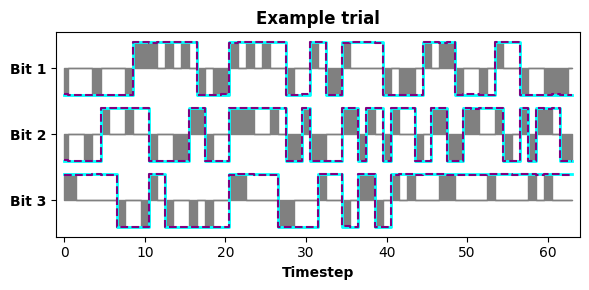

In [4]:
model, valid_predictions = train_FlipFlop(train_mode=1)

## STEP 2: Find, analyze, and visualize the fixed points of the trained RNN


In [5]:
def find_fixed_points(model, valid_predictions):
    ''' Find, analyze, and visualize the fixed points of the trained RNN.

    Args:
        model: FlipFlop object.

            Trained RNN model, as returned by train_FlipFlop().

        valid_predictions: dict.

            Model predictions on validation trials, as returned by
            train_FlipFlop().

    Returns:
        None.
    '''

    '''Initial states are sampled from states observed during realistic
    behavior of the network. Because a well-trained network transitions
    instantaneously from one stable state to another, observed networks states
    spend little if any time near the unstable fixed points. In order to
    identify ALL fixed points, noise must be added to the initial states
    before handing them to the fixed point finder. In this example, the noise
    needed is rather large, which can lead to identifying fixed points well
    outside of the domain of states observed in realistic behavior of the
    network--such fixed points can be safely ignored when interpreting the
    dynamical landscape (but can throw visualizations).'''

    NOISE_SCALE = 0.5 # Standard deviation of noise added to initial states
    N_INITS = 1024 # The number of initial states to provide

    n_bits = model.hps.data_hps['n_bits']
    is_lstm = model.hps.rnn_type == 'lstm'

    '''Fixed point finder hyperparameters. See FixedPointFinder.py for detailed
    descriptions of available hyperparameters.'''
    fpf_hps = {}

    # Setup the fixed point finder
    fpf = FixedPointFinder(model.rnn_cell, model.session, **fpf_hps)

    # Study the system in the absence of input pulses (e.g., all inputs are 0)
    inputs = np.zeros([1,n_bits])

    '''Draw random, noise corrupted samples of those state trajectories
    to use as initial states for the fixed point optimizations.'''
    initial_states = fpf.sample_states(valid_predictions['state'],
        n_inits=N_INITS,
        noise_scale=NOISE_SCALE)

    # Run the fixed point finder
    unique_fps, all_fps = fpf.find_fixed_points(initial_states, inputs)
    
    return unique_fps, all_fps

In [6]:
unique_fps, all_fps = find_fixed_points(model, valid_predictions)


Searching for fixed points from 1024 initial states.

	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		526 iters
		q = 1.37e-14 +/- 2.34e-14
		dq = 1.58e-14 +/- 2.79e-13
		learning rate = 1.96e+01
		avg iter time = 4.88e-03 sec
	Identified 27 unique fixed points.
		initial_states: 0 outliers detected (of 1024).
		fixed points: 0 outliers detected (of 27).
	Computing recurrent Jacobian at 27 unique fixed points.
	Computing input Jacobian at 27 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



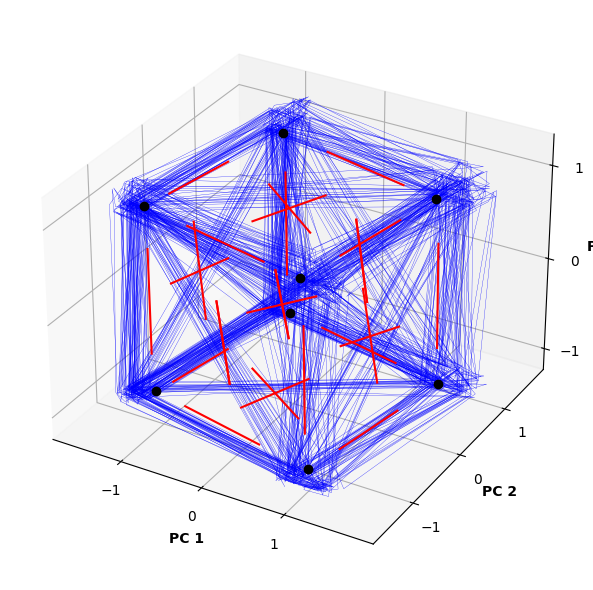

	Updating Tensorboard images.
	Saving SESO visualizations.


In [7]:
# Visualize identified fixed points with overlaid RNN state trajectories
# All visualized in the 3D PCA space fit the the example RNN states.
fig = plot_fps(unique_fps, valid_predictions['state'],
    plot_batch_idx=list(range(30)),
    plot_start_time=10)

model.save_visualizations(figs={'fixed_points': fig})